In [283]:
import torch
from torch import nn,optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [284]:
with open("data/names.txt","r") as f:
    words = f.read().lower().split('\n')
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [285]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda" 
    if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [286]:
chars = sorted(list(set(''.join(words))))
str_to_idx = {c:i+1 for i,c in enumerate(chars)}
str_to_idx['.'] = 0
idx_to_str = {i:c for c,i in str_to_idx.items()}

In [287]:
seq_len = 10
block_size = seq_len
embed_sz = 3
hidden_sz = 10
vocab_size = len(str_to_idx)

In [288]:
def build_dateset(words):
    X, Y = [],[]
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = str_to_idx[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    return torch.tensor(X).to(device),torch.tensor(Y).to(device)

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dateset(words[:n1])
Xdev,Ydev = build_dateset(words[n1:n2])
Xte,Yte = build_dateset(words[n2:])
[tmp.shape for tmp in (Xtr,Ytr,Xdev,Ydev,Xte,Yte)]

[torch.Size([182625, 10]),
 torch.Size([182625]),
 torch.Size([22655, 10]),
 torch.Size([22655]),
 torch.Size([22866, 10]),
 torch.Size([22866])]

# VALINA RNN

In [289]:
class RNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Embedding(vocab_size,embed_sz),
            nn.Flatten(),
        )
        self.rnn = nn.RNN(
            input_size = embed_sz,
            hidden_size = hidden_sz,
            num_layers = 1,
            batch_first = True,
        )
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(block_size*hidden_sz,200),
            nn.Tanh(),
            nn.Linear(200, vocab_size),
            nn.LogSoftmax(1),
        )
    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0),block_size,embed_sz)
        x,h = self.rnn(x)
        x = self.main(x)
        return x

model = RNN_Model().to(device)
print("--in--")
tmp = Xtr[2:7]
# print(tmp)
print(tmp.shape)
out = model(tmp)
print("--out--")
# print(out)
print(out.shape)

--in--
torch.Size([5, 10])
--out--
torch.Size([5, 27])


In [290]:
# optimization configurations
loss_fn = nn.CrossEntropyLoss()
epochs = 1000
max_learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=max_learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_learning_rate,
    total_steps=epochs,
)

In [291]:
train_lossi = []
test_lossi = []

In [292]:
for i in range(epochs):
    # mini batching
    idx = torch.randperm(Xtr.size(0))[:2**16]
    X = Xtr[idx]
    y = Ytr[idx]
    # X = Xtr
    # y = Ytr
    # forward pass
    pred = model(X)
    loss = loss_fn(pred,y)
    
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    # tracing
    train_lossi.append(loss.item())
    with torch.no_grad():
        pred = model(Xte)
        loss = loss_fn(pred,Yte)
        test_lossi.append(loss.item())
    if i % 100 == 0:
        print(i,loss.item())
# 2.1701

0 3.315277338027954
100 2.536857843399048
200 2.3206441402435303
300 2.206662654876709
400 2.155235767364502
500 2.123838186264038
600 2.105048656463623
700 2.0942208766937256
800 2.0875160694122314
900 2.0854833126068115


In [293]:
with torch.no_grad():
    pred = model(Xdev)
    loss = loss_fn(pred,Ydev)
    print(loss.item())

2.089592456817627


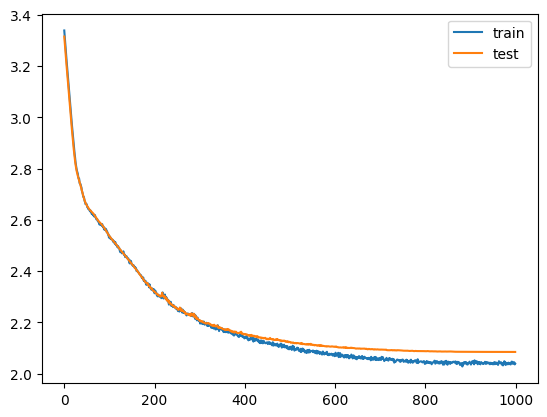

In [294]:
plt.plot(train_lossi[::],label='train')
plt.plot(test_lossi[::],label='test')
plt.legend()

In [295]:
g = torch.Generator(device).manual_seed(42)
for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor(context).to(device).view(1,-1))
        ix = torch.multinomial(logits.exp(),num_samples=1,generator=g).item()
        context = context[1:] +[ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(idx_to_str[i] for i in out))

kritani.
rogennon.
dagar.
everion.
rishai.
